In [16]:
import tensorflow as tf
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from skimage import exposure
from skimage import feature
import matplotlib.pyplot as plt

def import_data() -> ((np.ndarray, np.ndarray), (np.ndarray, np.ndarray)):
    return tf.keras.datasets.cifar100.load_data(label_mode="coarse")

In [17]:
(x_train, y_train), (x_test, y_test) = import_data()
og_image = np.copy(x_train[0])

#### Converting Images to Grayscale

In [18]:
def convert_to_grayscale(train, test):
    rgb_weights = [0.2989, 0.5870, 0.1140]
    gray_train = np.dot(train[:][...,:3], rgb_weights)
    gray_test = np.dot(test[:][...,:3], rgb_weights)
    return gray_train.astype(int), gray_test.astype(int)

#### Increasing Constrast

In [19]:
def increase_image_contrast(image, strength):
    p_low, p_high = np.percentile(image, (strength, 100 - strength))
    return (exposure.rescale_intensity(image, in_range=(p_low, p_high))).astype(int)

def increase_all_contrast(train, test, strength=10):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = increase_image_contrast(train[i], strength)
    for i in range(len(test)):
        new_test[i] = increase_image_contrast(test[i], strength)
    return new_train, new_test

#### Image Equalization

In [20]:
def equalize_hist(image):
    return (exposure.equalize_hist(image) * 255).astype(int)

def equalize_hist_all(train, test):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = equalize_hist(train[i])
    for i in range(len(test)):
        new_test[i] = equalize_hist(test[i])
    return new_train, new_test

In [21]:
def equalize_adapthist(image, clip_lim):
    return (exposure.equalize_adapthist(image, clip_limit=clip_lim) * 255).astype(int)

def equalize_adapthist_all(train, test, clip_limit=0.03):
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = equalize_adapthist(train[i], clip_limit)
    for i in range(len(test)):
        new_test[i] = equalize_adapthist(test[i], clip_limit)
    return new_train, new_test

In [22]:
img_rescale = increase_image_contrast(og_image, 20)
hist_eq_image = equalize_hist(og_image)
img_adapteq = equalize_adapthist(og_image, 0.02)

C:\tools\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


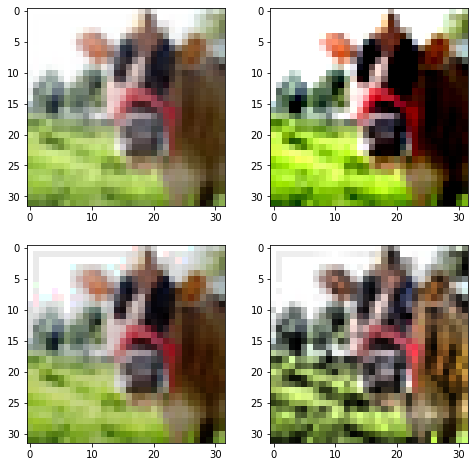

In [23]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2 
rows = 2
images = [og_image, img_rescale, hist_eq_image, img_adapteq]
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i - 1])
plt.show()

#### Edge Detection

In [24]:
def canny_edge_filter_all(train, test, sig=1):
    if (len(train.shape) > 3):
        train, test = convert_to_grayscale(train, test)
    new_train = np.copy(train)
    new_test = np.copy(test)
    for i in range(len(train)):
        new_train[i] = feature.canny(train[i].astype(float), sigma=sig)
    for i in range(len(test)):
        new_test[i] = feature.canny(test[i].astype(float), sigma=sig)
    return new_train, new_test

#### Centering & PCA

In [25]:
def centre_data(train, test):
    column_means = np.mean(train, axis=0)
    
    for i in range(len(train)):
        train[i] = train[i] - column_means
    for x in range(len(test)):
        test[x] = test[x] - column_means
        
    return train, test

In [26]:
def pca(training_data, testing_data, variance_target=0.8):
    U, sigma, Vt = np.linalg.svd(training_data, full_matrices=False)
    sum_square_singular = np.sum(sigma**2)
    
    ratios = sigma**2/sum_square_singular       
    n_components = 0
    explained_variance = 0
    
    for i in range(len(ratios)):
        if explained_variance >= variance_target:
            break
        else: 
            n_components += 1
            explained_variance += ratios[i]
    
    return training_data.dot(Vt.T[:, :n_components]), testing_data.dot(Vt.T[:, :n_components])

#### Flattening the Images

In [27]:
def flatten_data(x_train, y_train, x_test, y_test):
    new_image_shape = 1
    for dim in range(1, len(x_train.shape)):
        new_image_shape *= x_train.shape[dim]
        
    flat_x_train = x_train.reshape((x_train.shape[0], new_image_shape))
    flat_y_train = np.ravel(y_train)
    
    flat_x_test = x_test.reshape((x_test.shape[0], new_image_shape))
    flat_y_test = np.ravel(y_test)
    return flat_x_train, flat_y_train, flat_x_test, flat_y_test

### Training and Testing Model

In [28]:
(x_train, y_train), (x_test, y_test) = import_data()

# x_train, x_test = convert_to_grayscale(x_train, x_test)

# x_train, x_test = increase_all_contrast(x_train, x_test, 10)

# x_train, x_test = equalize_hist_all(x_train, x_test)

# x_train, x_test = equalize_adapthist_all(x_train, x_test, 0.03)

# x_train, x_test = canny_edge_filter_all(x_train, x_test, 0)

x_train, y_train, x_test, y_test = flatten_data(x_train, y_train, x_test, y_test)

# x_train, x_test = centre_data(x_train, x_test)

# x_train, x_test = pca(x_train, x_test, 0.8)

In [29]:
model = RandomForestClassifier(
    n_jobs=-1, 
    verbose=1,
    n_estimators=100,
    bootstrap=False, 
    max_features='log2', 
    criterion='gini')
model.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.4s finished


RandomForestClassifier(bootstrap=False, max_features='log2', n_jobs=-1,
                       verbose=1)

In [30]:
model.score(x_test, y_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


0.3366

### Testing

In [31]:
import time
import csv

In [32]:
def nano_to_seconds(nanoseconds):
    """Converts nanoseconds to seconds rounded to the nearest 5 decimal places.
    
    Parameters
    ----------
    nanoseconds : int
        The nanoseconds to convert
    """

    return np.round((nanoseconds / 1e+9), 5)

In [33]:
def test_random_forest_estimators():
    num_estimators = list(range(100, 1001, 100)) + [1250, 1500, 1750, 2000]
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = import_data()
    with open('rf_estimators.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Number Estimators', 'Max Features', 'Criterion', 'Bootstrap', 'Average Accuracy', 'Average Runtime'])
        max_features = 'log2'
        criterion = 'gini'
        bootstrap = False
        for n_estimators in num_estimators:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(2):
                x_train, y_train, x_test, y_test = flatten_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
                model = RandomForestClassifier(
                            n_jobs=-1, 
                            verbose=0,
                            n_estimators=n_estimators,
                            bootstrap=bootstrap, 
                            max_features=max_features, 
                            criterion=criterion)
                start_time = time.time_ns()
                model.fit(x_train, y_train)
                total_accuracy += model.score(x_test, y_test)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([n_estimators, max_features, criterion, bootstrap, avg_accuracy, avg_runtime])
            print("Finished n_estimators: {}".format(n_estimators))

In [34]:
# test_random_forest_estimators()

In [35]:
def test_random_forest_max_features():
    max_features_list = ['sqrt', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = import_data()
    with open('rf_features.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Number Estimators', 'Max Features', 'Criterion', 'Bootstrap', 'Average Accuracy', 'Average Runtime'])
        n_estimators = 100
        criterion = 'gini'
        bootstrap = False
        for max_features in max_features_list:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            iterations = 1
            if max_features == "sqrt" or max_features == "log2":
                iterations = 5
            for i in range(iterations):
                x_train, y_train, x_test, y_test = flatten_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
                model = RandomForestClassifier(
                            n_jobs=-1, 
                            verbose=0,
                            n_estimators=n_estimators,
                            bootstrap=bootstrap, 
                            max_features=max_features, 
                            criterion=criterion)
                start_time = time.time_ns()
                model.fit(x_train, y_train)
                total_accuracy += model.score(x_test, y_test)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([n_estimators, max_features, criterion, bootstrap, avg_accuracy, avg_runtime])
            print("Finished max_features: {}".format(max_features))

In [36]:
# test_random_forest_max_features()

In [37]:
def test_random_forest_criterion():
    criterion_list = ['gini', 'entropy']
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = import_data()
    with open('rf_criterion.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Number Estimators', 'Max Features', 'Criterion', 'Bootstrap', 'Average Accuracy', 'Average Runtime'])
        n_estimators = 100
        max_features = 'log2'
        bootstrap = False
        for criterion in criterion_list:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            for i in range(5):
                x_train, y_train, x_test, y_test = flatten_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
                model = RandomForestClassifier(
                            n_jobs=-1, 
                            verbose=0,
                            n_estimators=n_estimators,
                            bootstrap=bootstrap, 
                            max_features=max_features, 
                            criterion=criterion)
                start_time = time.time_ns()
                model.fit(x_train, y_train)
                total_accuracy += model.score(x_test, y_test)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([n_estimators, max_features, criterion, bootstrap, avg_accuracy, avg_runtime])
            print("Finished criterion: {}".format(criterion))

In [38]:
# test_random_forest_criterion()

In [39]:
def test_random_forest_bootstrap():
    max_samples_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
    bootstrap_list = [False, True]
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = import_data()
    with open('rf_bootstrap.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Number Estimators', 'Max Features', 'Criterion', 'Bootstrap', 'Max Samples', 'Average Accuracy', 'Average Runtime'])
        n_estimators = 100
        criterion = 'gini'
        max_features = 'log2'
        max_samples = 1.0
        for bootstrap in bootstrap_list:
            if not bootstrap:
                num_tests = 0
                total_accuracy = 0
                total_runtime = 0
                for i in range(5):
                    x_train, y_train, x_test, y_test = flatten_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
                    model = RandomForestClassifier(
                                n_jobs=-1, 
                                verbose=0,
                                n_estimators=n_estimators,
                                bootstrap=bootstrap, 
                                max_features=max_features, 
                                criterion=criterion)
                    start_time = time.time_ns()
                    model.fit(x_train, y_train)
                    total_accuracy += model.score(x_test, y_test)
                    end_time = time.time_ns()
                    total_runtime += nano_to_seconds(end_time - start_time)
                    num_tests += 1
                avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
                avg_runtime = np.round(total_runtime / float(num_tests), 5)
                result_writer.writerow([n_estimators, max_features, criterion, bootstrap, max_samples, avg_accuracy, avg_runtime])
                print("Finished bootstrap: {}".format(bootstrap))
            else:
                for item in max_samples_list:
                    max_samples = item
                    num_tests = 0
                    total_accuracy = 0
                    total_runtime = 0
                    for i in range(5):
                        x_train, y_train, x_test, y_test = flatten_data(raw_x_train, raw_y_train, raw_x_test, raw_y_test)
                        model = RandomForestClassifier(
                                    n_jobs=-1, 
                                    verbose=0,
                                    n_estimators=n_estimators,
                                    bootstrap=bootstrap,
                                    max_samples=max_samples,
                                    max_features=max_features, 
                                    criterion=criterion)
                        start_time = time.time_ns()
                        model.fit(x_train, y_train)
                        total_accuracy += model.score(x_test, y_test)
                        end_time = time.time_ns()
                        total_runtime += nano_to_seconds(end_time - start_time)
                        num_tests += 1
                    avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
                    avg_runtime = np.round(total_runtime / float(num_tests), 5)
                    result_writer.writerow([n_estimators, max_features, criterion, bootstrap, max_samples, avg_accuracy, avg_runtime])
                    print("Finished bootstrap - max_samples: {} - {}".format(bootstrap, max_samples))

In [40]:
# test_random_forest_bootstrap()

In [41]:
def test_random_forest_image_filter():
    techniques = ['none', 'grayscale', 'hist equalization', 'adaptive equalization', 'canny']
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = import_data()
    with open('rf_filter.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Number Estimators', 'Max Features', 'Criterion', 'Bootstrap', 'Technique', 'Average Accuracy', 'Average Runtime'])
        n_estimators = 100
        max_features = 'log2'
        bootstrap = False
        criterion = 'gini'
        for technique in techniques:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            x_train = np.copy(raw_x_train)
            y_train = np.copy(raw_y_train)
            x_test = np.copy(raw_x_test)
            y_test = np.copy(raw_y_test)
            if technique == 'grayscale':
                x_train, x_test = convert_to_grayscale(raw_x_train, raw_x_test)
            elif technique == 'hist equalization':
                x_train, x_test = equalize_hist_all(raw_x_train, raw_x_test)
            elif technique == 'adaptive equalization':
                x_train, x_test = equalize_adapthist_all(raw_x_train, raw_x_test)
            elif technique == 'canny':
                x_train, x_test = canny_edge_filter_all(raw_x_train, raw_x_test, 0)
            x_train, y_train, x_test, y_test = flatten_data(x_train, y_train, x_test, y_test)
            for i in range(5):
                model = RandomForestClassifier(
                            n_jobs=-1, 
                            verbose=0,
                            n_estimators=n_estimators,
                            bootstrap=bootstrap, 
                            max_features=max_features, 
                            criterion=criterion)
                start_time = time.time_ns()
                model.fit(x_train, y_train)
                total_accuracy += model.score(x_test, y_test)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([n_estimators, max_features, criterion, bootstrap, technique, avg_accuracy, avg_runtime])
            print("Finished technique: {}".format(technique))

In [42]:
# test_random_forest_image_filter()

In [43]:
def test_random_forest_contrast_stretching():
    stretch_factor = list(range(0, 46, 5))
    (raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = import_data()
    with open('rf_contrast.csv', mode='w', newline='') as csv_file:
        result_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        result_writer.writerow(['Number Estimators', 'Max Features', 'Criterion', 'Bootstrap', 'Contrast Strength', 'Average Accuracy', 'Average Runtime'])
        n_estimators = 100
        max_features = 'log2'
        bootstrap = False
        criterion = 'gini'
        for strength in stretch_factor:
            num_tests = 0
            total_accuracy = 0
            total_runtime = 0
            x_train, x_test = increase_all_contrast(raw_x_train, raw_x_test, strength)
            x_train, y_train, x_test, y_test = flatten_data(x_train, raw_y_train, x_test, raw_y_test)
            for i in range(5):
                model = RandomForestClassifier(
                            n_jobs=-1, 
                            verbose=0,
                            n_estimators=n_estimators,
                            bootstrap=bootstrap, 
                            max_features=max_features, 
                            criterion=criterion)
                start_time = time.time_ns()
                model.fit(x_train, y_train)
                total_accuracy += model.score(x_test, y_test)
                end_time = time.time_ns()
                total_runtime += nano_to_seconds(end_time - start_time)
                num_tests += 1
            avg_accuracy = np.round(total_accuracy / float(num_tests), 5)
            avg_runtime = np.round(total_runtime / float(num_tests), 5)
            result_writer.writerow([n_estimators, max_features, criterion, bootstrap, strength, avg_accuracy, avg_runtime])
            print("Finished strength: {}".format(strength))

In [44]:
# test_random_forest_contrast_stretching()